## Multi-class Classification

### 1. Create the dataset

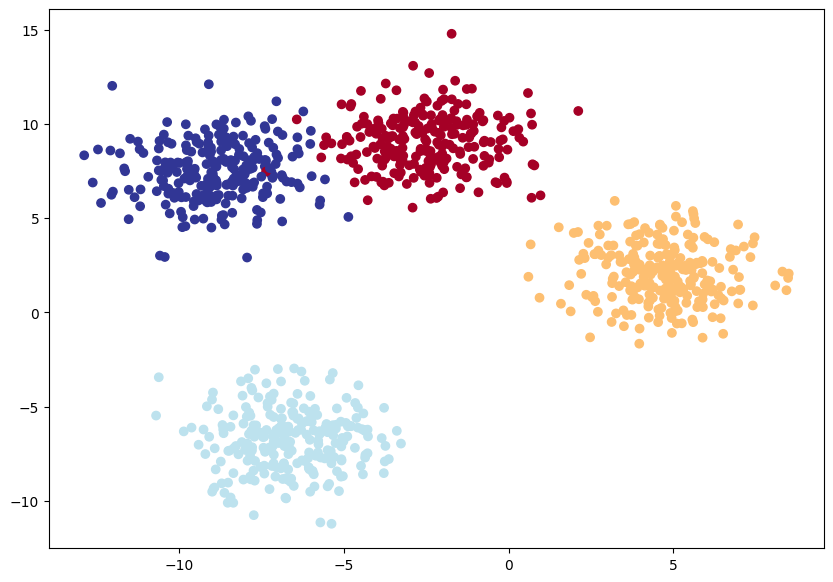

In [ ]:
import torch
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#set hyperparameters for dataset
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob,y_blob = make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES,
                           centers=NUM_CLASSES,
                           cluster_std=1.5,
                           random_state=RANDOM_SEED)
# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split to train and test
X_train,X_test,y_train,y_test = train_test_split(X_blob,
                                                 y_blob,
                                                 test_size=0.2,
                                                 random_state=RANDOM_SEED)
# 4. Plot the data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

In [ ]:
X_train.shape

torch.Size([800, 2])

In [ ]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 2. Construct the model

In [ ]:
from torch import nn

class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  def forward(self,x:torch.Tensor):
    return self.linear_layer_stack(x)

In [ ]:
model_0 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_0

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 3. Creating loss function and optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
def accuracy_fn(y_true,y_input):
  correct = torch.eq(y_true,y_input).sum().item()
  return (correct/len(y_input))*100

### 4. Visualise the model

In [ ]:
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test)
  y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)

y_preds[:5]

tensor([1, 0, 0, 0, 0], device='cuda:0')

### 5. Training Loop

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

epochs = 100

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train)
  y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_train,y_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test)
    test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_test,test_preds)

  if epoch%10==0:
    print(f"Epoch: {epochs} | Loss: {loss:.5f} | Acc:{acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")


Epoch: 100 | Loss: 1.15883 | Acc:40.38% | Test Loss: 1.07554 | Test Acc: 48.00%
Epoch: 100 | Loss: 0.64476 | Acc:96.75% | Test Loss: 0.66069 | Test Acc: 97.50%
Epoch: 100 | Loss: 0.42535 | Acc:98.50% | Test Loss: 0.43074 | Test Acc: 100.00%
Epoch: 100 | Loss: 0.25294 | Acc:99.12% | Test Loss: 0.24508 | Test Acc: 99.50%
Epoch: 100 | Loss: 0.11232 | Acc:99.25% | Test Loss: 0.10229 | Test Acc: 99.50%
Epoch: 100 | Loss: 0.06627 | Acc:99.25% | Test Loss: 0.05848 | Test Acc: 99.50%
Epoch: 100 | Loss: 0.05068 | Acc:99.25% | Test Loss: 0.04293 | Test Acc: 99.50%
Epoch: 100 | Loss: 0.04300 | Acc:99.25% | Test Loss: 0.03491 | Test Acc: 99.50%
Epoch: 100 | Loss: 0.03836 | Acc:99.25% | Test Loss: 0.02988 | Test Acc: 99.50%
Epoch: 100 | Loss: 0.03525 | Acc:99.25% | Test Loss: 0.02663 | Test Acc: 99.50%


### 6. Visualize

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_decision_boundary(model:nn.Module,X:torch.Tensor,y:torch.Tensor):
  model = model.to("cpu")
  X,y = X.to("cpu"),y.to("cpu")

  x_min,x_max = X[:,0].min(),X[:,0].max()
  y_min,y_max = X[:,1].min(),X[:,1].max()

  xx,yy = np.meshgrid(np.linspace(x_min,x_max,101),np.linspace(y_min,y_max,101))

  X_for_preds = torch.from_numpy(np.column_stack((xx.ravel(),yy.ravel()))).float()

  model.eval()
  with torch.inference_mode():
    y_logits = model(X_for_preds)

  y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)
  y_preds = y_preds.reshape(xx.shape)

  plt.contourf(xx,yy,y_preds,cmap=plt.cm.RdYlBu,alpha=0.7)
  plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu,s=40)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

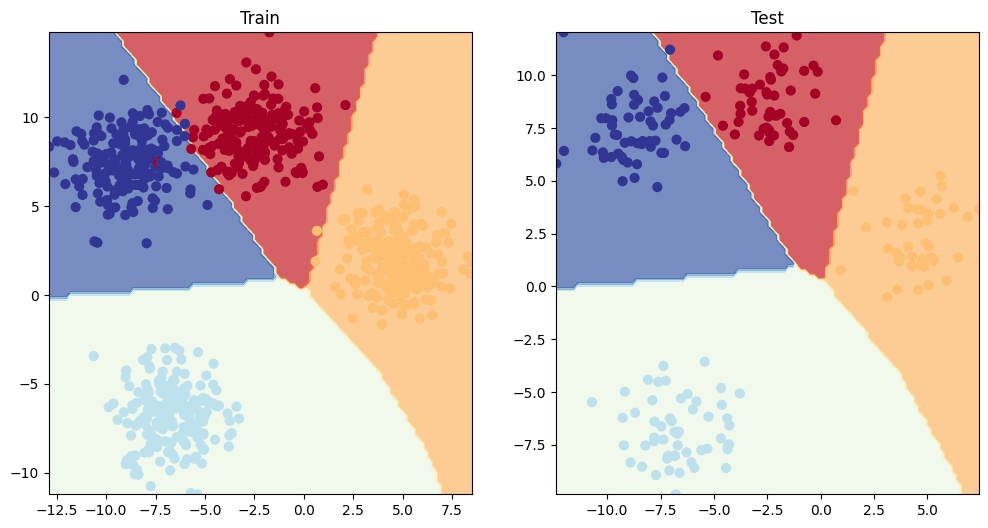

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

## Few More Classification Metrics

* Accuracy
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report -> scikit learn